In [1]:
import sys
sys.path.append("../src/py")

In [2]:
import pickle as pk
import re
import os
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logging.basicConfig(format="%(asctime)s %(levelname)-4s %(message)s",
                    level=logging.INFO,
                    datefmt="%d-%m-%Y %H:%M:%S")

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import random_split

from patch_dataset import CLPatchDataset

from torchvision.models.resnet import resnet18, ResNet18_Weights

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

from py.byol import MapBYOL

In [3]:
def show_patch_pairs(patches):
    for patch_1, patch_2 in patches:
        fig, ax = plt.subplots(1,2,figsize = (10,5))
        ax[0].imshow(patch_1.patch)
        ax[1].imshow(patch_2.patch)
        plt.show()

In [4]:
sorted(["batch_1", "batch_2", "batch_10", "batch_5"], key = natural_keys)

NameError: name 'natural_keys' is not defined

In [ ]:
len("batch_loss_logs")

In [ ]:
class Evaluator():
    def __init__(self):
        pass
    
    @staticmethod
    def natural_keys(text):
        '''
        alist.sort(key=natural_keys) sorts in human order
        http://nedbatchelder.com/blog/200712/human_sorting.html
        (See Toothy's implementation in the comments)
        '''

        atoi = lambda text: int(text) if text.isdigit() else text

        return [ atoi(c) for c in re.split(r'(\d+)', text) ]
    
    @staticmethod
    def load_log(log_dir):
        logs = []
        with open(log_dir, "rb") as f:
            logs = pk.load(f)
            
        return logs
    
    @staticmethod
    def join_logs(log_dir, start = 0, end = -1):
        all_logs = []
        loaded_logs = 0
        for log in sorted(os.listdir(log_dir), key = Plotter.natural_keys)[start:end]:
            if log[:15] == "batch_loss_logs":
                all_logs.extend(Plotter.load_log(os.path.join(log_dir, log)))
                loaded_logs += 1
                    
        return all_logs, loaded_logs
    
    @staticmethod
    def plot_loss_from_logs(log_dir, mean_interval = None, 
                            plot_running_mean = False, 
                            plot_interval = None,
                            start = 0, end = -1, 
                            c = "b", title = None, figsize = (5,5)):
        all_logs, loaded_logs = Plotter.join_logs(log_dir, start = start, end = end)
        
        if plot_interval is not None:
            all_logs = [all_logs[i] for i in range(len(all_logs)) if i % plot_interval == 0]
            
        mean_logs = []
        
        if mean_interval is not None:
            mean_logs = [np.mean(all_logs[i:i+mean_interval]) for i in range(len(all_logs) - mean_interval)]
            
            if title is None:
                title = f"Loss for Batches [{start + 1}-{start + loaded_logs}]"
                
            mean_title = title + f" (Averaged with Window {mean_interval})"
            
            fig, ax = plt.subplots(2, 1, figsize = figsize)
            fig.tight_layout(pad = 5)
            ax = ax.flatten()
            ax[0].plot(all_logs, c = c)
            ax[1].plot(mean_logs, c = c)
            ax[0].set_title(title)
            ax[1].set_title(mean_title)
            
            plt.setp(ax, xlabel = "Batch", ylabel = "Loss")
            
            plt.show()
        else:
            if title is None:
                title = f"Loss for Batches [{start + 1}-{start + loaded_logs - 1}]"

            fig, ax = plt.subplots(figsize = figsize)
            ax.plot(all_logs, c = c)
            ax.set_title(title)
            ax.set_xlabel("Batch")
            ax.set_xlabel("Loss")
            plt.show()
        
        return all_logs, mean_logs

    @staticmethod
    def cosine_similarity(x_1, x_2):
      return F.cosine_similarity(x_1, x_2, dim = 0)
        
    
    @staticmethod
    def show_patch_pairs(patches, figsize = (10,5), use_similarity = False):
        """
        Given a list of tuples, plots each of them side by side.
        """
        for patch_1, patch_2 in patches:
            fig, ax = plt.subplots(1,2,figsize = figsize)
            ax[0].imshow(patch_1.patch)
            ax[1].imshow(patch_2.patch)

            if use_similarity and patch_1.patch_shift is not None and patch_2.patch_shift is not None:
              plt.suptitle(f"Cosine Similarity: {Evaluator.cosine_similarity(patch_1.patch_shift, patch_2.patch_shift)}")
            plt.show()
            
    @staticmethod
    def load_checkpoint(checkpoint_dir):
        return torch.load(checkpoint_dir, map_location=torch.device('cpu'))
    
    @staticmethod
    def load_dataset(dataset_dir):
        dataset = None
        
        with open(dataset_dir, "rb") as f:
            dataset = pk.load(f)
            
        return dataset
    
    @staticmethod
    def load_model_from_checkpoint(checkpoint_dir, model, model_kwargs = None):
        checkpoint = Evaluator.load_checkpoint(checkpoint_dir)
        
        try:
            if "model_kwargs" in checkpoint:
                cl_model = model(**checkpoint["model_kwargs"])
            else:
                cl_model = model(**model_kwargs)
        except:
            logging.info("No model was loaded. Invalid arguments provided")
            logging.info(f"Kwargs provided: {model_kwargs}")
            logging.info(f"Kwargs found in checkpoint: {checkpoint['model_kwargs']}")
            
        cl_model.load_state_dict(state_dict = checkpoint["model_state_dict"])
        
        cl_model.eval()
            
        return cl_model

    @staticmethod
    def set_embeddings(model, dataset, batch_size):
      with torch.no_grad():
        device = model.device 
        dataloader = DataLoader(dataset, batch_size = batch_size, 
                            shuffle = False, drop_last = False, 
                            num_workers = 2)

        model.to(device)


        start_i = 0
        for batch, (x_1, x_2) in enumerate(dataloader):
          x_1_emb = model(x_1.to(device)).cpu()
          x_2_emb = model(x_2.to(device)).cpu()
          l = len(x_1_emb)

          stop_i = start_i + l

          torch.cuda.empty_cache()

          for batch_i, i  in enumerate(range(start_i, stop_i)):
            dataset.X_1[i].patch_shift = x_1_emb[batch_i]
            dataset.X_2[i].patch_shift = x_2_emb[batch_i]

          del x_1
          del x_2
          del x_1_emb
          del x_2_emb
          torch.cuda.empty_cache()

          start_i = stop_i

      return dataloader

In [ ]:
logs = Plotter.join_logs("../src/py/output/b-presnet18-e5-b32-t0_99-p128/")

In [ ]:
all_logs, mean_logs = Plotter.plot_loss_from_logs("../src/py/output/b-presnet18-e5-b32-t0_99-p128/", 
                            plot_interval = None,
                            mean_interval = 20,
                            start = 0, end = -1,
                            c = "b", title = None, figsize = (10,7))

In [ ]:
projector_18_parameters = {"input_dim": 512,
                               "hidden_dim": 2048,
                               "output_dim": 256,
                               "activation": nn.ReLU(),
                               "use_bias": True,
                               "use_batch_norm": True}

predictor_parameters = {"input_dim": 256,
                        "hidden_dim": 1024,
                        "output_dim": 256,
                        "activation": nn.ReLU(),
                        "use_bias": True,
                        "use_batch_norm": True}

encoder = resnet18(weights=ResNet18_Weights.DEFAULT)

byol_nn = Plotter.load_model_from_checkpoint("../src/py/output/b-presnet18-e5-b32-t0_99-p128/byol_checkpoint.pt",
                                             MapBYOL,
                                             model_kwargs = {"encoder" : encoder,
                                                            "encoder_layer_idx" : -2,
                                                            "projector_parameters" : projector_18_parameters,
                                                            "predictor_parameters" : predictor_parameters,
                                                            "ema_tau" : 0.99})

In [ ]:
val_dataset = Evaluator.load_dataset("gdrive/MyDrive/data/patch_val_dataset_128.pk")
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False, drop_last = False, num_workers = 2)

with torch.no_grad():
  device = byol_nn.device 

  byol_nn.to(device)


  start_i = 0
  for batch, (x_1, x_2) in enumerate(val_loader):
    x_1_emb = byol_nn(x_1.to(device)).cpu()
    x_2_emb = byol_nn(x_2.to(device)).cpu()
    l = len(x_1_emb)

    stop_i = start_i + l

    torch.cuda.empty_cache()

    for batch_i, i  in enumerate(range(start_i, stop_i)):
      val_dataset.X_1[i].patch_shift = x_1_emb[batch_i]
      val_dataset.X_2[i].patch_shift = x_2_emb[batch_i]

    del x_1
    del x_2
    del x_1_emb
    del x_2_emb
    torch.cuda.empty_cache()

    start_i = stop_i

In [ ]:
patch_pairs = [(val_dataset.X_1[i], val_dataset.X_2[i]) for i in range(10)]
wrong_patch_pairs = [(val_dataset.X_1[i], val_dataset.X_2[i*5]) for i in range(10)]

In [ ]:
Evaluator.show_patch_pairs(patch_pairs, use_similarity = True)
Evaluator.show_patch_pairs(wrong_patch_pairs, use_similarity = True)

In [5]:
with open("py/output/5_epochs/batch_loss_logs_0.pk", "rb") as f:
    batch_loss_0 = [t.detach() for t in pk.load(f)]
    
with open("py/output/5_epochs/batch_loss_logs_1.pk", "rb") as f:
    batch_loss_1 = [t.detach() for t in pk.load(f)]
    
with open("py/output/5_epochs/batch_loss_logs_2.pk", "rb") as f:
    batch_loss_2 = [t.detach() for t in pk.load(f)]

with open("py/output/5_epochs/batch_loss_logs_3.pk", "rb") as f:
    batch_loss_3 = [t.detach() for t in pk.load(f)]

with open("py/output/5_epochs/batch_loss_logs_4.pk", "rb") as f:
    batch_loss_4 = [t.detach() for t in pk.load(f)]

In [12]:
batch_loss = batch_loss_0 + batch_loss_1 + batch_loss_2 + batch_loss_3 + batch_loss_4

In [14]:
avg_batch_loss = [np.mean(batch_loss[i:i+20]) for i in range(len(batch_loss) - 20)]

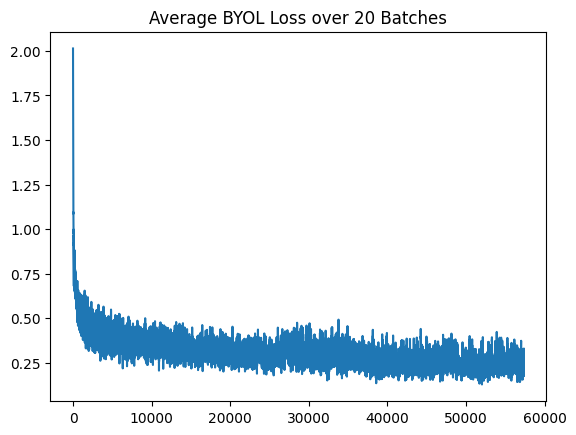

In [16]:
fig, ax = plt.subplots()
ax.plot(avg_batch_loss)
ax.set_title("Average BYOL Loss over 20 Batches")
fig.savefig("py/output/5_epochs/batch_loss_plot.png")
plt.show()